# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков (лучше выполнять действия сразу для двух датасетов)
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    Выводить R2 и строит графики для оценки качества модели
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов

In [9]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [12]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [13]:
train_df[train_df['Floor'] > train_df['HouseFloor']].shape[0]

1825

In [14]:
train_df[train_df['LifeSquare'] > train_df['Square']].shape[0]

482

In [15]:
train_df[train_df['KitchenSquare'] > train_df['Square']].shape[0]

4

In [16]:
train_df[train_df['HouseYear'] > 2021].shape[0]

2

In [17]:
train_df.replace({'Ecology_2' : {'A' : 1, 'B' : 2}}, inplace = True)
train_df.replace({'Ecology_3' : {'A' : 1, 'B' : 2}}, inplace = True)
train_df.replace({'Shops_2' : {'A' : 1, 'B' : 2}}, inplace = True)

test_df.replace({'Ecology_2' : {'A' : 1, 'B' : 2}}, inplace = True)
test_df.replace({'Ecology_3' : {'A' : 1, 'B' : 2}}, inplace = True)
test_df.replace({'Shops_2' : {'A' : 1, 'B' : 2}}, inplace = True)

### Обзор данных

**Целевая переменная**

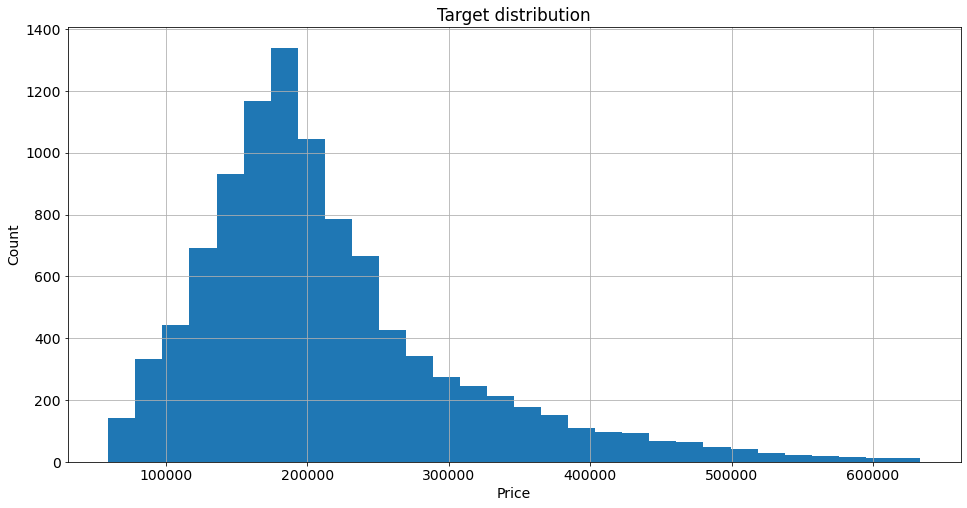

In [18]:
# логнормальное распределение
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

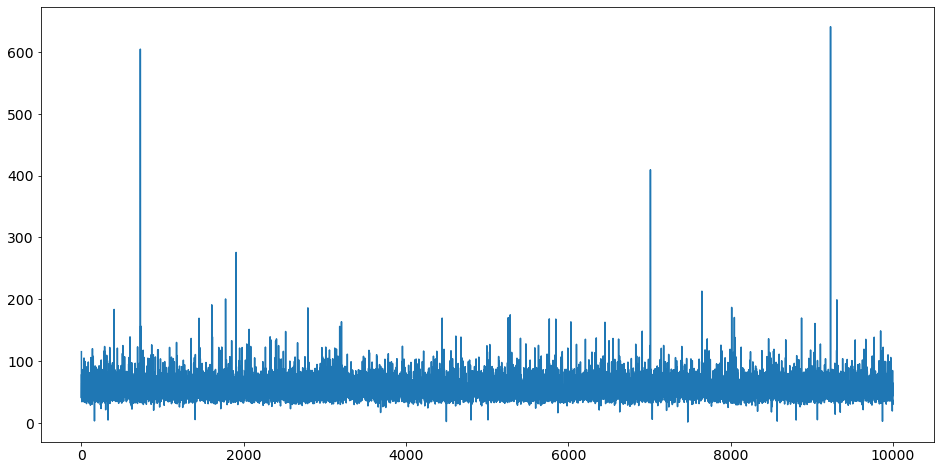

In [19]:
plt.figure(figsize = (16, 8))

train_df['Square'].plot()
plt.show()

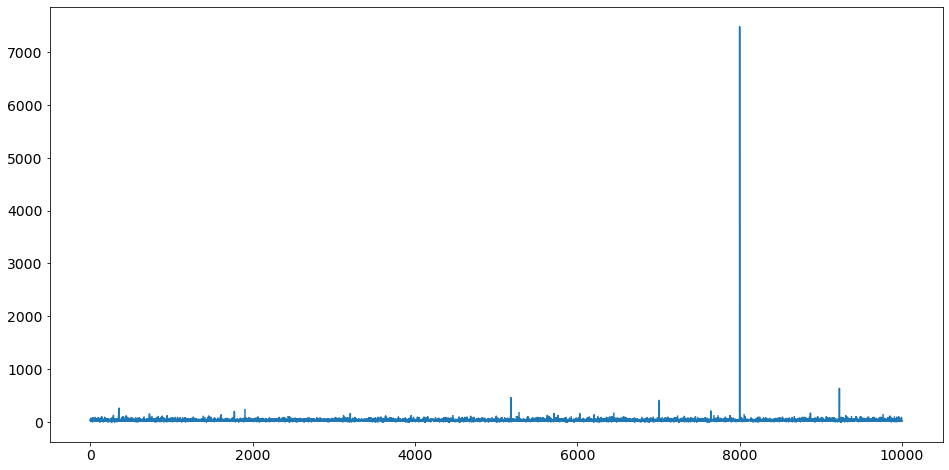

In [20]:
plt.figure(figsize = (16, 8))

train_df['LifeSquare'].plot()
plt.show()

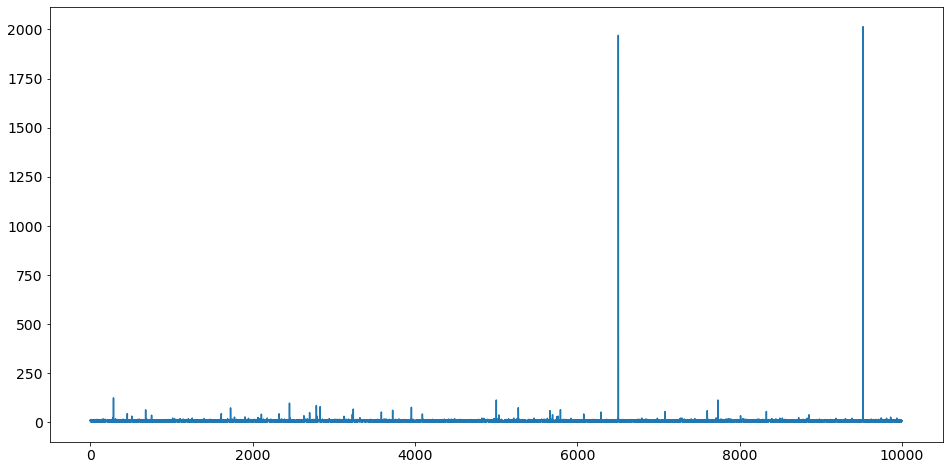

In [21]:
plt.figure(figsize = (16, 8))

train_df['KitchenSquare'].plot()
plt.show()

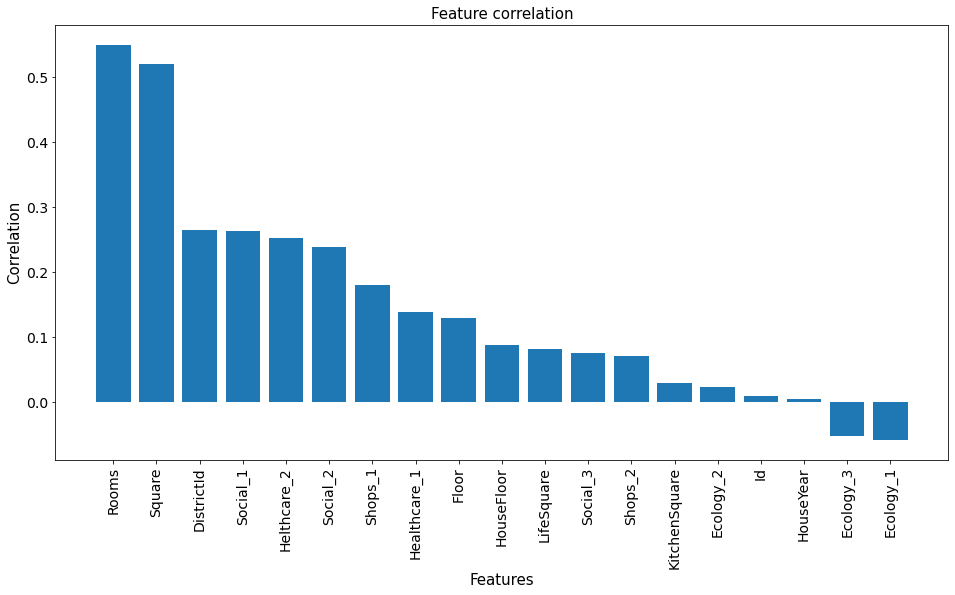

In [22]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

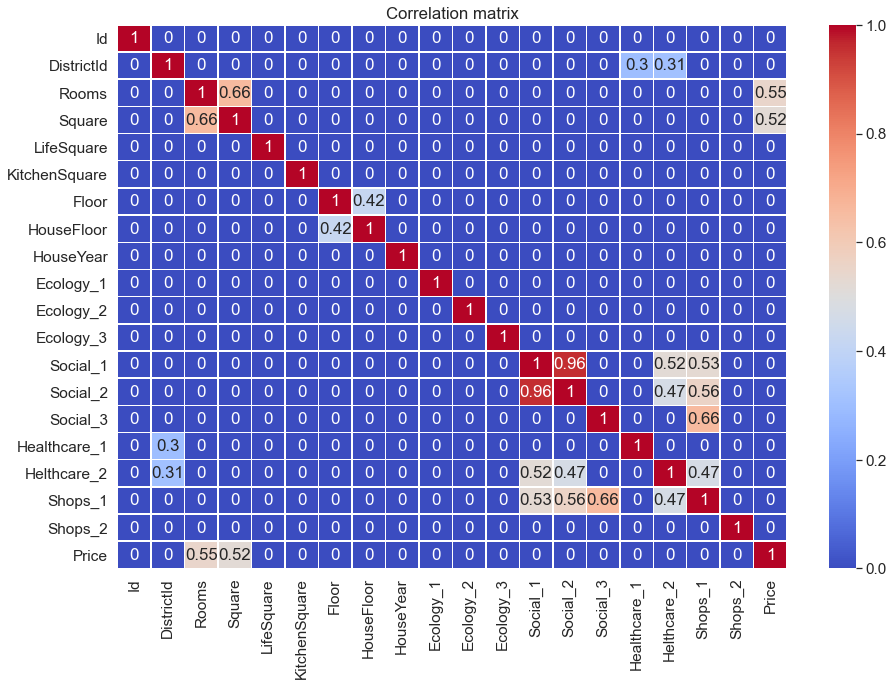

In [23]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [24]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
        self.square_max = None
        self.square_min = None
        self.kitchen_square_max = None
        self.kitchen_square_min = None
        self.life_square_max = None
        self.life_square_min = None
        self.districts_healthcare = None
        self.district_sm_price = None
        
    def fit(self, df):
        """Сохранение статистик"""
        # Расчет медиан
        self.medians = df.median()
        self.square_max = np.quantile(df['Square'], q = 0.9) 
        self.square_min = np.quantile(df['Square'], q = 0.1) 
        self.kitchen_square_max = np.quantile(df['KitchenSquare'], q = 0.95) 
        self.kitchen_square_min = np.quantile(df['KitchenSquare'], q = 0.05) 
        self.lfie_square_max = np.quantile(df['LifeSquare'], q = 0.95) 
        self.life_square_min = np.quantile(df['LifeSquare'], q = 0.05)
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('median').to_dict()
        self.district_sm_price = df.groupby(['DistrictId'])['Price'].agg('median') / df.groupby(['DistrictId'])['Square'].agg('median')
        self.district_sm_price_dict = self.district_sm_price.to_dict()
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        #df.fillna(self.medians, inplace = True)
        df['LifeSquare'].fillna((df['Square'] - df['KitchenSquare']), inplace = True)  
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)  
        
        # 2. Выбросы (outliers)
        df['HouseFloor'], df['Floor'] = np.where(df['Floor'] > df['HouseFloor'],(df['Floor'],df['HouseFloor']),(df['HouseFloor'],df['Floor']))
        df.loc[(df['Square'] > self.square_max) | (df['Square'] < self.square_min), 'Square'] = df['KitchenSquare'] + df['LifeSquare']
        df.loc[(df['KitchenSquare'] > df['Square']), 'KitchenSquare'] = df['Square'] - df['LifeSquare']
        df.loc[(df['LifeSquare'] > df['Square']), 'LifeSquare'] = df['Square'] - df['KitchenSquare']
        df.loc[(df['HouseYear'] > 2021), 'HouseYear'] = self.medians.HouseYear        
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        
        # 3. Новые фичи (features)        
        df['DistrictSMPrice'] = df['DistrictId'].map(self.district_sm_price_dict)
        #self.district_sm_price = df['DistrictSMPrice'].median()
        df['DistrictSMPrice'].fillna(df['DistrictSMPrice'].median(), inplace=True)

        df.fillna(self.medians, inplace=True)
        return df

In [25]:
pipe = DataPipeline()
pipe.fit(train_df)
pipe.transform(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               10000 non-null  int64  
 1   DistrictId       10000 non-null  int64  
 2   Rooms            10000 non-null  float64
 3   Square           10000 non-null  float64
 4   LifeSquare       10000 non-null  float64
 5   KitchenSquare    10000 non-null  float64
 6   Floor            10000 non-null  float64
 7   HouseFloor       10000 non-null  float64
 8   HouseYear        10000 non-null  float64
 9   Ecology_1        10000 non-null  float64
 10  Ecology_2        10000 non-null  int64  
 11  Ecology_3        10000 non-null  int64  
 12  Social_1         10000 non-null  int64  
 13  Social_2         10000 non-null  int64  
 14  Social_3         10000 non-null  int64  
 15  Healthcare_1     10000 non-null  float64
 16  Helthcare_2      10000 non-null  int64  
 17  Shops_1      

In [26]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

In [27]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)



GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)

In [28]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.8543837313270213
0.7623305899195291


**Перекрёстная проверка**

In [29]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictSMPrice']

target_name = 'Price'

X = train_df[feature_names + new_feature_names]

In [30]:
cv_score = cross_val_score(
    gb_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.78076534, 0.72780885, 0.74348331, 0.76027437, 0.78272273])

In [31]:
cv_score.mean(), cv_score.std()

(0.7590109216134552, 0.021221577685742805)

In [32]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7377893439277123, 0.780232499299198)

**Важность признаков**

In [33]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.246419
19,DistrictSMPrice,0.199291
2,Rooms,0.111034
4,LifeSquare,0.085975
12,Social_1,0.060443
13,Social_2,0.057052
5,KitchenSquare,0.047413
8,HouseYear,0.033804
1,DistrictId,0.032295
14,Social_3,0.028552


## Формирование файла с прогнозами

In [34]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [35]:
pipe.transform(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSMPrice
0,4567,44,1.0,24.094182,19.094182,5.0,5.0,9.0,1970.0,0.036122,2,2,24,4378,0,1036.0,1,1,2,4431.704675
1,5925,62,1.0,42.493907,32.493907,10.0,7.0,17.0,2017.0,0.072158,2,2,2,629,1,900.0,0,0,1,2859.977368
2,960,27,2.0,59.463678,50.463678,9.0,19.0,19.0,1977.0,0.211401,2,2,9,1892,0,900.0,0,1,2,2669.535159
3,3848,23,3.0,49.646030,33.893825,6.0,2.0,2.0,1965.0,0.014073,2,2,2,475,0,900.0,0,0,2,2109.194622
4,746,74,1.0,53.837056,52.837056,1.0,8.0,17.0,1977.0,0.309479,2,2,35,7715,4,990.0,0,6,2,3483.810063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,5.0,6.0,1962.0,0.069660,2,2,31,6119,4,900.0,1,2,2,4190.624398
4996,16138,38,3.0,104.521465,94.521465,10.0,21.0,27.0,2018.0,0.060753,2,2,15,2787,2,520.0,0,7,2,5033.548791
4997,3912,101,1.0,24.003259,19.003259,5.0,2.0,5.0,1966.0,0.038693,2,2,28,6533,1,1015.0,2,5,2,3970.074724
4998,5722,10,1.0,38.635155,20.976257,9.0,8.0,14.0,1970.0,0.089040,2,2,33,7976,5,900.0,0,11,2,4368.622761


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               5000 non-null   int64  
 1   DistrictId       5000 non-null   int64  
 2   Rooms            5000 non-null   float64
 3   Square           5000 non-null   float64
 4   LifeSquare       5000 non-null   float64
 5   KitchenSquare    5000 non-null   float64
 6   Floor            5000 non-null   float64
 7   HouseFloor       5000 non-null   float64
 8   HouseYear        5000 non-null   float64
 9   Ecology_1        5000 non-null   float64
 10  Ecology_2        5000 non-null   int64  
 11  Ecology_3        5000 non-null   int64  
 12  Social_1         5000 non-null   int64  
 13  Social_2         5000 non-null   int64  
 14  Social_3         5000 non-null   int64  
 15  Healthcare_1     5000 non-null   float64
 16  Helthcare_2      5000 non-null   int64  
 17  Shops_1       

In [37]:
predictions = gb_model.predict(test_df)
predictions

array([160281.62200204, 111036.96098505, 142811.67066045, ...,
       156306.31049853, 190909.58794621, 293658.3399663 ])

In [38]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,160281.622002
1,5925,111036.960985
2,960,142811.670660
3,3848,108294.210851
4,746,181440.588314


In [39]:
submit.to_csv('predictions_.csv', index=False)